In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
import torch
import torch.nn as nn

In [4]:
data = pd.read_csv('clean.csv')

In [5]:
data

,date,AQI,latitude,longitude
0,2023-04-01 00:00:00,45.765,27.889417,71.375264
1,2023-04-01 01:00:00,46.520,27.889417,71.375264
2,2023-04-01 02:00:00,47.640,27.889417,71.375264
3,2023-04-01 03:00:00,49.330,27.889417,71.375264
4,2023-04-01 04:00:00,51.210,27.889417,71.375264
...,...,...,...,...
9236,2024-04-19 20:00:00,64.075,27.889417,71.375264
9237,2024-04-19 21:00:00,64.950,27.889417,71.375264
9238,2024-04-19 22:00:00,63.735,27.889417,71.375264
9239,2024-04-19 23:00:00,61.845,27.889417,71.375264


In [6]:
data = data[['date', 'AQI']]
data

,date,AQI
0,2023-04-01 00:00:00,45.765
1,2023-04-01 01:00:00,46.520
2,2023-04-01 02:00:00,47.640
3,2023-04-01 03:00:00,49.330
4,2023-04-01 04:00:00,51.210
...,...,...
9236,2024-04-19 20:00:00,64.075
9237,2024-04-19 21:00:00,64.950
9238,2024-04-19 22:00:00,63.735
9239,2024-04-19 23:00:00,61.845


In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\timmy\AppData\Local\Temp\ipykernel_22252\3395756933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


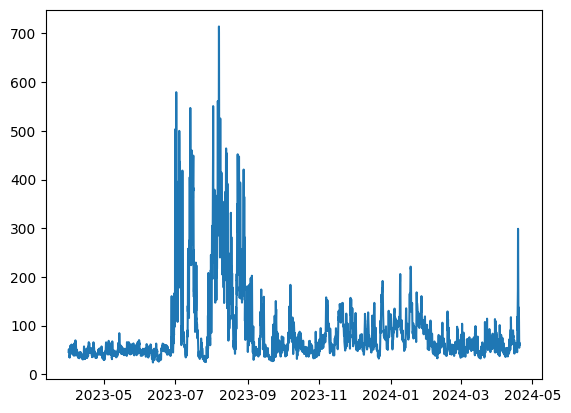

In [8]:
data['date'] = pd.to_datetime(data['date'])

plt.plot(data['date'], data['AQI'])

In [9]:
from copy import deepcopy as dc

def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 24
shifted_df = prepare_data(data, lookback)
shifted_df

,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6),AQI(t-7),AQI(t-8),AQI(t-9),...,AQI(t-15),AQI(t-16),AQI(t-17),AQI(t-18),AQI(t-19),AQI(t-20),AQI(t-21),AQI(t-22),AQI(t-23),AQI(t-24)
date,,,,,,,,,,,,,,,,,,,,,
2023-04-02 00:00:00,34.430,35.995,36.750,37.130,36.865,36.430,36.180,35.925,35.645,35.360,...,42.035,44.425,47.205,49.650,51.400,51.210,49.330,47.640,46.520,45.765
2023-04-02 01:00:00,35.175,34.430,35.995,36.750,37.130,36.865,36.430,36.180,35.925,35.645,...,40.915,42.035,44.425,47.205,49.650,51.400,51.210,49.330,47.640,46.520
2023-04-02 02:00:00,36.520,35.175,34.430,35.995,36.750,37.130,36.865,36.430,36.180,35.925,...,40.240,40.915,42.035,44.425,47.205,49.650,51.400,51.210,49.330,47.640
2023-04-02 03:00:00,38.645,36.520,35.175,34.430,35.995,36.750,37.130,36.865,36.430,36.180,...,34.950,40.240,40.915,42.035,44.425,47.205,49.650,51.400,51.210,49.330
2023-04-02 04:00:00,40.920,38.645,36.520,35.175,34.430,35.995,36.750,37.130,36.865,36.430,...,34.805,34.950,40.240,40.915,42.035,44.425,47.205,49.650,51.400,51.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-19 20:00:00,64.075,61.375,57.480,54.325,55.820,68.255,86.095,105.880,118.880,128.115,...,121.295,116.905,109.050,95.440,111.915,126.265,143.585,162.995,185.515,211.040
2024-04-19 21:00:00,64.950,64.075,61.375,57.480,54.325,55.820,68.255,86.095,105.880,118.880,...,125.655,121.295,116.905,109.050,95.440,111.915,126.265,143.585,162.995,185.515
2024-04-19 22:00:00,63.735,64.950,64.075,61.375,57.480,54.325,55.820,68.255,86.095,105.880,...,130.535,125.655,121.295,116.905,109.050,95.440,111.915,126.265,143.585,162.995


In [10]:
# converting to an array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 34.43 ,  35.995,  36.75 , ...,  47.64 ,  46.52 ,  45.765],
       [ 35.175,  34.43 ,  35.995, ...,  49.33 ,  47.64 ,  46.52 ],
       [ 36.52 ,  35.175,  34.43 , ...,  51.21 ,  49.33 ,  47.64 ],
       ...,
       [ 63.735,  64.95 ,  64.075, ..., 126.265, 143.585, 162.995],
       [ 61.845,  63.735,  64.95 , ..., 111.915, 126.265, 143.585],
       [ 60.765,  61.845,  63.735, ...,  95.44 , 111.915, 126.265]])

In [11]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((9217, 24), (9217,))

In [12]:
X = dc(np.flip(X, axis=1))
X

array([[ 45.765,  46.52 ,  47.64 , ...,  37.13 ,  36.75 ,  35.995],
       [ 46.52 ,  47.64 ,  49.33 , ...,  36.75 ,  35.995,  34.43 ],
       [ 47.64 ,  49.33 ,  51.21 , ...,  35.995,  34.43 ,  35.175],
       ...,
       [162.995, 143.585, 126.265, ...,  61.375,  64.075,  64.95 ],
       [143.585, 126.265, 111.915, ...,  64.075,  64.95 ,  63.735],
       [126.265, 111.915,  95.44 , ...,  64.95 ,  63.735,  61.845]])

In [13]:
# scaling the data
from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()
target_scaler = StandardScaler()
X = data_scaler.fit_transform(X)
y = target_scaler.fit_transform(y.reshape(-1, 1))


In [14]:
# saving the scaler
import joblib

joblib.dump(data_scaler, 'data_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

['target_scaler.pkl']

In [15]:
# loading the scaler
data_scaler = joblib.load('data_scaler.pkl')
target_scaler = joblib.load('target_scaler.pkl')

In [16]:
split_index = int(len(X) * 0.98)

split_index

9032

In [17]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9032, 24), (185, 24), (9032, 1), (185, 1))

In [18]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9032, 24, 1), (185, 24, 1), (9032, 1), (185, 1))

In [19]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9032, 24, 1]),
 torch.Size([185, 24, 1]),
 torch.Size([9032, 1]),
 torch.Size([185, 1]))

In [20]:
# Creating a dataset
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [21]:
train_dataset

In [22]:
# Data Loader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 24, 1]) torch.Size([16, 1])


In [24]:
# LSTM Model


class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out



In [25]:
model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1 }')

  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100==99: # printing every 100 batch
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
  print()

In [27]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [26]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.929
Batch 200, Loss: 0.670
Batch 300, Loss: 0.579
Batch 400, Loss: 0.424
Batch 500, Loss: 0.397

Val Loss: 0.067
***************************************************

Epoch: 2
Batch 100, Loss: 0.179
Batch 200, Loss: 0.156
Batch 300, Loss: 0.169
Batch 400, Loss: 0.130
Batch 500, Loss: 0.162

Val Loss: 0.027
***************************************************

Epoch: 3
Batch 100, Loss: 0.111
Batch 200, Loss: 0.075
Batch 300, Loss: 0.063
Batch 400, Loss: 0.056
Batch 500, Loss: 0.063

Val Loss: 0.018
***************************************************

Epoch: 4
Batch 100, Loss: 0.056
Batch 200, Loss: 0.049
Batch 300, Loss: 0.037
Batch 400, Loss: 0.055
Batch 500, Loss: 0.043

Val Loss: 0.013
***************************************************

Epoch: 5
Batch 100, Loss: 0.058
Batch 200, Loss: 0.040
Batch 300, Loss: 0.035
Batch 400, Loss: 0.033
Batch 500, Loss: 0.024

Val Loss: 0.010
***************************************************

Epoch: 6
Batch 100, Loss: 0.02

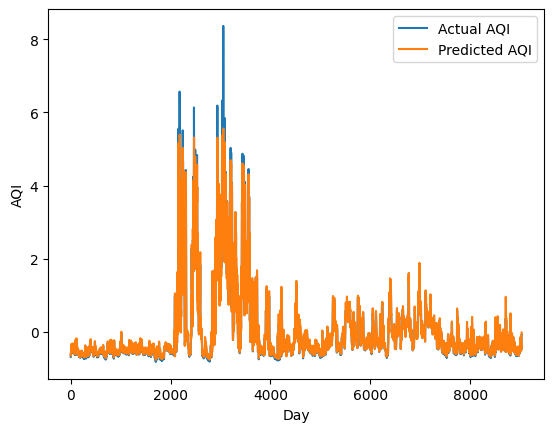

In [27]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual AQI')
plt.plot(predicted, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [28]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = target_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([38.34424083, 36.78033918, 37.9283282 , ..., 69.23314226,
       81.43485562, 84.65714912])

In [29]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = target_scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([34.42999783, 35.17499933, 36.52000218, ..., 74.85000016,
       80.87500018, 80.70999981])

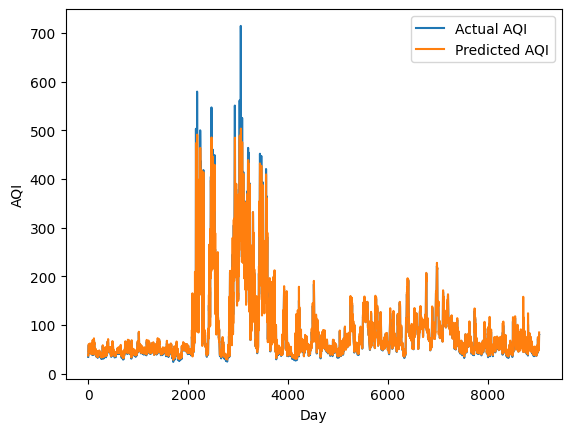

In [30]:
plt.plot(new_y_train, label='Actual AQI')
plt.plot(train_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [31]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = target_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 80.26648092,  77.28549032,  78.78940303,  86.83083994,
        96.83006295,  64.84583065,  97.89769525, 124.53060376,
       122.71815794, 100.4028156 ,  91.97570221,  87.98875551,
        80.88503302,  77.77569096,  72.75924728,  64.00890339,
        59.79020887,  60.76920486,  62.100938  ,  61.04781064,
        62.82957725,  69.45393864,  77.67768753,  76.4609153 ,
        72.03921433,  68.8590214 ,  69.22827745,  74.3190897 ,
        85.8047622 ,  67.16973104,  75.21066222,  75.81990986,
        72.10835557,  70.00119234,  67.66249163,  65.19020767,
        63.67332511,  63.73367209,  65.64537   ,  69.21070683,
        70.97800878,  62.06762275,  63.06672246,  64.40458697,
        69.30632036,  77.86084537,  85.36583681,  87.4738101 ,
        88.36514095,  89.67455055,  90.51014413,  90.03661902,
        88.25092296,  86.73984506,  84.900005  ,  79.08953573,
        75.91675863,  77.59926868,  78.01707442,  78.15033993,
        77.85874191,  78.72743593,  77.82049023,  76.44

In [32]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = target_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 78.86999975,  78.98000018,  83.81500012,  91.52500023,
        73.88500003,  89.29500012, 108.34500043, 117.08499933,
       108.11500029,  98.90999978,  92.12499991,  84.98000005,
        80.33500008,  75.22500045,  67.51999998,  61.98499921,
        60.7400003 ,  61.16500033,  60.58000069,  61.7350005 ,
        66.59500031,  73.50499954,  75.26499979,  73.27500051,
        70.48499979,  69.65500052,  72.57499967,  80.68499994,
        71.61499974,  74.37500039,  75.04500004,  73.0950001 ,
        71.07999983,  68.73499993,  66.22000002,  64.30000015,
        63.66500077,  64.72999926,  67.45999985,  69.56500032,
        64.28500068,  63.43500062,  63.84499894,  67.25000049,
        73.89000023,  80.93000012,  85.00999998,  87.27999999,
        88.93499987,  90.03000011,  90.1500001 ,  89.09500004,
        87.72499997,  86.00500001,  81.68000014,  78.06000015,
        77.67500003,  77.70999973,  77.88499994,  77.79999994,
        78.34500024,  77.96499975,  76.99499998,  77.79

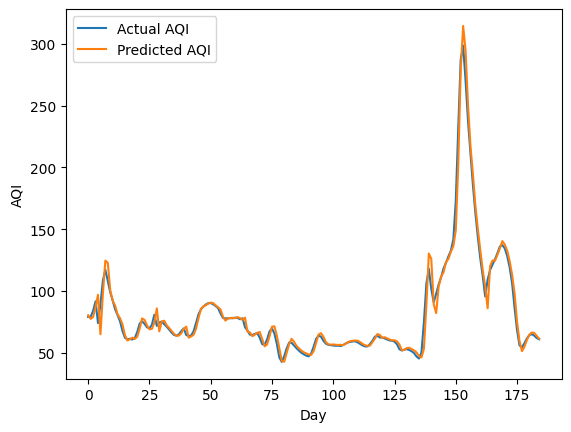

In [33]:
plt.plot(new_y_test, label='Actual AQI')
plt.plot(test_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [34]:
# Saving the model

torch.save(model.state_dict(), "lstm_model.pt")  # Replace "lstm_model.pt" with your desired filename

## Testing section

In [43]:
def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 16

In [44]:
def model_data(df):
    df['date'] = pd.to_datetime(df['date'])
    shifted_df = prepare_data(df, lookback)
    shifted_df_as_np = shifted_df.to_numpy()

    # preparing the data for the model
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    # flipping X
    X = dc(np.flip(X, axis=1))
    # loading the scaler
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # scaling the data
    scaled_data = data_scaler.transform(X)
    scald_target = target_scaler.transform(y.reshape(-1, 1))
    
    # reshaping X and y
    X_ = scaled_data.reshape((-1, lookback, 1))
    y_ = scald_target.reshape((-1, 1))
    # converting to tensor
    X_ = torch.tensor(X_).float().to(device)
    y_ = torch.tensor(y_).float().to(device)
    # now using the dataset class
    dataset = TimeSeriesDataset(X_, y_)
    # creating a dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, X_, y_

# model loading function
def load_model():
    model = LSTM(1, 4, 1)
    model.to(device)
    # Load the state dictionaries
    model.load_state_dict(torch.load("lstm_model.pt"))
    return model


def predict(dataloader):
    model = load_model()
    model.eval()
    predictions = []
    y_ = []
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            predictions.append(y_pred)
            y_.append(y)
    return predictions, y_

In [45]:
import pandas as pd
def create_hourly_increments(date):
    # getting the next date
    date = pd.to_datetime(date)
    next_date = date + pd.DateOffset(days=4)
    return pd.date_range(start=date, end=next_date,  freq='H')
    
def get_date_data(date):
    df = pd.read_csv('clean.csv')
    df['date'] = pd.to_datetime(df['date'])
    # convert date to datetime
    date_dt = pd.to_datetime(date)
    # getting the hourly increments for the selected date
    hourly_df = pd.DataFrame({'date': create_hourly_increments(date)})
    data_ = df[df['date'].isin(hourly_df['date'].astype(str).values.tolist())]
    return data_

d = get_date_data('2024-04-14')


C:\Users\timmy\AppData\Local\Temp\ipykernel_22252\1251811244.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range(start=date, end=next_date,  freq='H')
C:\Users\timmy\AppData\Local\Temp\ipykernel_22252\1251811244.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  data_ = df[df['date'].isin(hourly_df['date'].astype(str).values.tolist())]


In [46]:
d

,date,AQI,latitude,longitude
9096,2024-04-14 00:00:00,64.285,27.889417,71.375264
9097,2024-04-14 01:00:00,63.435,27.889417,71.375264
9098,2024-04-14 02:00:00,63.845,27.889417,71.375264
9099,2024-04-14 03:00:00,67.250,27.889417,71.375264
9100,2024-04-14 04:00:00,73.890,27.889417,71.375264
...,...,...,...,...
9188,2024-04-17 20:00:00,51.075,27.889417,71.375264
9189,2024-04-17 21:00:00,49.505,27.889417,71.375264
9190,2024-04-17 22:00:00,46.760,27.889417,71.375264
9191,2024-04-17 23:00:00,45.170,27.889417,71.375264


In [47]:
len(d)

97

In [48]:
loader, x, y = model_data(d[['date', 'AQI']])

C:\Users\timmy\AppData\Local\Temp\ipykernel_22252\3864368778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [49]:
model = load_model()
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [50]:
predictions, y = predict(loader)

In [51]:
predictions

[tensor([[-0.1053],
         [-0.2570],
         [-0.2645],
         [-0.3049],
         [-0.2890],
         [-0.2683],
         [-0.2596],
         [-0.3387],
         [-0.4142],
         [-0.3945],
         [-0.3049],
         [-0.2018],
         [-0.1989],
         [-0.3019],
         [-0.4351],
         [-0.5716]]),
 tensor([[-0.5799],
         [-0.4823],
         [-0.3884],
         [-0.3335],
         [-0.3660],
         [-0.4094],
         [-0.4371],
         [-0.4597],
         [-0.4792],
         [-0.4914],
         [-0.5030],
         [-0.5071],
         [-0.4650],
         [-0.3758],
         [-0.2870],
         [-0.2724]]),
 tensor([[-0.3122],
         [-0.3697],
         [-0.3932],
         [-0.3964],
         [-0.3943],
         [-0.3968],
         [-0.4001],
         [-0.3975],
         [-0.4022],
         [-0.3870],
         [-0.3685],
         [-0.3584],
         [-0.3554],
         [-0.3515],
         [-0.3541],
         [-0.3694]]),
 tensor([[-0.3887],
         [-0.4

In [52]:
y

[tensor([[-0.2087],
         [-0.2442],
         [-0.2887],
         [-0.2921],
         [-0.2803],
         [-0.2703],
         [-0.3212],
         [-0.3908],
         [-0.3982],
         [-0.3391],
         [-0.2527],
         [-0.2211],
         [-0.2771],
         [-0.3905],
         [-0.5351],
         [-0.5827]]),
 tensor([[-0.5191],
         [-0.4363],
         [-0.3741],
         [-0.3763],
         [-0.4060],
         [-0.4348],
         [-0.4611],
         [-0.4844],
         [-0.5009],
         [-0.5150],
         [-0.5223],
         [-0.4916],
         [-0.4177],
         [-0.3346],
         [-0.2978],
         [-0.3109]]),
 tensor([[-0.3545],
         [-0.3853],
         [-0.3984],
         [-0.4019],
         [-0.4053],
         [-0.4087],
         [-0.4078],
         [-0.4111],
         [-0.4007],
         [-0.3845],
         [-0.3723],
         [-0.3660],
         [-0.3610],
         [-0.3611],
         [-0.3720],
         [-0.3893]]),
 tensor([[-0.4055],
         [-0.4

In [53]:
# a function for making plot
def make_plot(predictions, y):
    scaler = joblib.load('target_scaler.pkl')   
    predictions = torch.cat(predictions).cpu().numpy().flatten()
    y = torch.cat(y).cpu().numpy().flatten()

    dummies = np.zeros((len(predictions), lookback+1))
    dummies[:, 0] = predictions
    dummies = scaler.inverse_transform(dummies)

    predictions = dc(dummies[:, 0])

    dummies = np.zeros((len(y), lookback+1))
    dummies[:, 0] = y.flatten()
    dummies = scaler.inverse_transform(dummies)

    new_y = dc(dummies[:, 0])

    plt.plot(new_y, label='Actual AQI')
    plt.plot(predictions, label='Predicted AQI')
    plt.xlabel('Hour')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

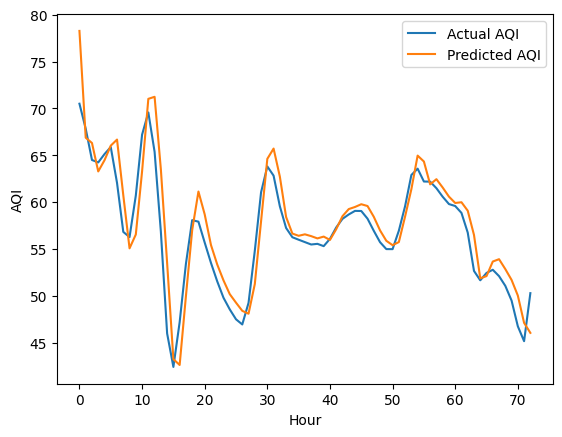

In [54]:
make_plot(predictions, y)

In [49]:
data_scaler = joblib.load('data_scaler.pkl')
data_scaler

StandardScaler()

In [62]:
def predict_today(n=24):
    # loading the database
    data = pd.read_csv('clean.csv')
    # getting today's date
    today_date = date.today()
    today_date = pd.to_datetime(today_date)
    # get last date in the data
    last_date = data['date'].iloc[-1]
    # converting both to time and getting the total hours between them
    last_date = pd.to_datetime(last_date)
    hours_diff = (today_date - last_date).total_seconds() / 3600
    aqi_data = data['AQI'].values.tolist()
    model = load_model()
    data_scaler = joblib.load('data_scaler.pkl')
    target_Scaler = joblib.load('target_scaler.pkl')
    lookback = 24
    # ensureing we are just collecting the last 6 values
    current_data = aqi_data[-lookback:]
    predictions = []
    for _ in range(int(hours_diff)):
        # Ensure current_data has the required length
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        # Prepare data for the model (scaling and reshaping)
        current_data_np = np.array([current_data])  # Assuming data is a list
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        # Make prediction
        with torch.no_grad():
            y_pred = model(X_)

        # Inverse scaling of the predicted value (assuming single value prediction)
        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        # Update current_data for the next iteration
        current_data.append(predicted_value)
        current_data = current_data[-lookback:]  # Keep only the last lookback values

        # Append the prediction to the final list
        predictions.append(predicted_value)

    return predictions[-24:]


In [63]:
pred = predict_today()
pred

[79.09733,
 79.140335,
 79.18271,
 79.22446,
 79.26562,
 79.3062,
 79.3462,
 79.38564,
 79.42453,
 79.46288,
 79.50071,
 79.53802,
 79.57483,
 79.61115,
 79.64701,
 79.68241,
 79.717354,
 79.75185,
 79.7859,
 79.81953,
 79.85273,
 79.88552,
 79.9179,
 79.94989]

In [73]:
# predicting for thr last seven days
def predict_last_seven_days():
    # getting the data
    data = pd.read_csv('clean.csv')
    # converting date to the right format
    data['date'] = pd.to_datetime(data['date'])
    # today's date
    today_date = date.today()
    # last seven days
    last_seven_days = today_date - timedelta(days=7)
    # converting to datetime
    today_date = pd.to_datetime(today_date)
    last_seven_days = pd.to_datetime(last_seven_days)
    # caalculating the hours difference
    hours_diff = (today_date - last_seven_days).days * 24
    # the prev day before the last seven days data
    previous_day_hrs = hours_diff + 24 
    # getting the data
    aqi_data = data['AQI'].values.tolist()[-previous_day_hrs:-hours_diff]
    # loading model
    model = load_model()
    # loading scalers
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # lookback
    lookback = 24
    # current data
    current_data = aqi_data[-lookback:]
    # predictions
    predictions = []
    # loop to make predictions
    for _ in range(hours_diff):
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        current_data_np = np.array([current_data])
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        with torch.no_grad():
            y_pred = model(X_)

        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        current_data.append(predicted_value)
        current_data = current_data[-lookback:]

        predictions.append(predicted_value)

    return predictions[-24*7:]

In [75]:
len(predict_last_seven_days())

168

In [76]:
# next seven days prediction
def predict_next_seven_days():
    # loading the database
    data = pd.read_csv('clean.csv')
    # getting today's date
    today_date = date.today()
    today_date = pd.to_datetime(today_date)
    # get last date in the data
    last_date = data['date'].iloc[-1]
    # converting both to time and getting the total hours between them
    last_date = pd.to_datetime(last_date)
    hours_diff = (today_date - last_date).total_seconds() / 3600
    # adding 168 to the hours diff
    hours_diff += 168
    aqi_data = data['AQI'].values.tolist()
    model = load_model()
    data_scaler = joblib.load('data_scaler.pkl')
    target_Scaler = joblib.load('target_scaler.pkl')
    lookback = 24
    # ensureing we are just collecting the last 6 values
    current_data = aqi_data[-lookback:]
    predictions = []
    for _ in range(int(hours_diff)):
        # Ensure current_data has the required length
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        # Prepare data for the model (scaling and reshaping)
        current_data_np = np.array([current_data])  # Assuming data is a list
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        # Make prediction
        with torch.no_grad():
            y_pred = model(X_)

        # Inverse scaling of the predicted value (assuming single value prediction)
        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        # Update current_data for the next iteration
        current_data.append(predicted_value)
        current_data = current_data[-lookback:]  # Keep only the last lookback values

        # Append the prediction to the final list
        predictions.append(predicted_value)

    return predictions[-168:]

In [78]:
predict_next_seven_days()

[79.98149,
 80.01271,
 80.04356,
 80.074036,
 80.10416,
 80.13394,
 80.16338,
 80.19248,
 80.22126,
 80.24972,
 80.277855,
 80.30568,
 80.33319,
 80.360405,
 80.38733,
 80.413956,
 80.4403,
 80.46636,
 80.49216,
 80.517685,
 80.542946,
 80.56794,
 80.59268,
 80.61717,
 80.64142,
 80.66542,
 80.689186,
 80.71271,
 80.736,
 80.75907,
 80.78193,
 80.804565,
 80.82699,
 80.84921,
 80.87122,
 80.89303,
 80.914635,
 80.93605,
 80.957275,
 80.97831,
 80.99915,
 81.0198,
 81.04026,
 81.06054,
 81.08063,
 81.10055,
 81.1203,
 81.139885,
 81.1593,
 81.17855,
 81.19765,
 81.21658,
 81.23536,
 81.25399,
 81.27248,
 81.29083,
 81.30903,
 81.32707,
 81.34498,
 81.36274,
 81.38036,
 81.39784,
 81.415184,
 81.432396,
 81.44948,
 81.46643,
 81.48327,
 81.49998,
 81.51657,
 81.533035,
 81.54938,
 81.5656,
 81.5817,
 81.597694,
 81.61357,
 81.62934,
 81.645,
 81.66054,
 81.67597,
 81.69131,
 81.706535,
 81.72167,
 81.7367,
 81.75163,
 81.76646,
 81.78118,
 81.79581,
 81.81033,
 81.82477,
 81.83911,
 81.8